In [295]:
import sys
nb_out = sys.stdout

In [488]:
import tsaugmentation as tsag
sys.stdout = nb_out
import matplotlib.pyplot as plt
from itertools import product
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn import preprocessing
from torch_geometric.utils import dense_to_sparse
import seaborn as sns
import numpy as np

In [297]:
data = tsag.preprocessing.PreprocessDatasets('tourism').apply_preprocess()

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 204
Total number of points: 228
Seasonality: 12
Forecast horizon: 24


In [496]:
train = data['predict']['data'].T.reshape(304, -1)[:,:228-12].T

In [497]:
train.shape

(216, 304)

In [534]:
test = data['predict']['data'].T.reshape(304, -1)[:,228-36:].T

In [535]:
test.shape

(36, 304)

The test dataset has this shape since we are performing multioutput forecasting: we are using the last 24 months of the train_dataset to predict the last 12 months of the dataset (only in the test dataset).

# Build the SUM Matrix

The SUM matrix to build:

$$ \begin{matrix} 1 & 1 & 1& 1 \\
1 & 1 & 0 & 0 \\
0 & 0 & 1 & 1\\
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1\end{matrix}$$

In [536]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [537]:
groups = []
for group in data['train']['groups_names'].keys():
    groups.append(data['train']['groups_names'][group][data['train']['groups_idx'][group]].reshape(-1,1))

In [538]:
groups_arr = np.squeeze(np.array(groups)).T

In [539]:
enc = OneHotEncoder().fit(groups_arr)

In [540]:
# SUM Matrix
S = np.concatenate((
    np.ones(data['train']['s']).reshape(1,-1),
    enc.transform(groups_arr).toarray().T,
    np.eye(data['train']['s'])),
    axis=0
)

In [541]:
visitors_train = (S @ train.T)

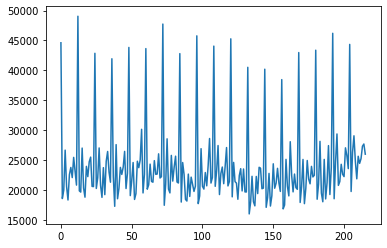

In [542]:
plt.plot(visitors_train[0]);

In [543]:
visitors_test = (S @ test.T)

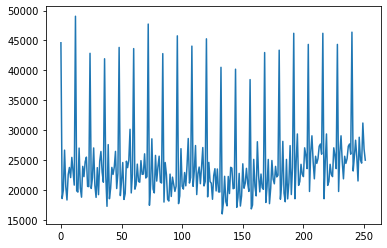

In [544]:
plt.plot(np.concatenate((visitors_train[0], visitors_test[0])));

# Static Graph Temporal Signal

### Extract the node features -> These are static

Features for each node:
- Average number of visits at that node
- Number of connections (e.g. top node has 4 connections -> state, zone, region, purpose)

Only use train data to avoid leaking information into the train set. 

In [545]:
average_node_visitors = visitors_train.mean(axis=1)
count_node_connections = S.sum(axis=1)

In [546]:
# Normalize features between 0 and 1
average_node_visitors = (average_node_visitors - np.min(average_node_visitors)) / (np.max(average_node_visitors) - np.min(average_node_visitors))
count_node_connections = (count_node_connections - np.min(count_node_connections)) / (np.max(count_node_connections) - np.min(count_node_connections))

In [547]:
node_features = np.concatenate((average_node_visitors.reshape(-1,1), count_node_connections.reshape(-1,1)), axis=1)

In [548]:
node_features.shape

(419, 2)

In [549]:
node_features[:20]

array([[1.        , 1.        ],
       [0.31807251, 0.18151815],
       [0.19558   , 0.27392739],
       [0.26063376, 0.15511551],
       [0.06922556, 0.15511551],
       [0.10093032, 0.06270627],
       [0.03142627, 0.06270627],
       [0.02382946, 0.08910891],
       [0.09250946, 0.02310231],
       [0.0874127 , 0.02310231],
       [0.04027146, 0.00990099],
       [0.03606461, 0.04950495],
       [0.0419951 , 0.04950495],
       [0.01956741, 0.00990099],
       [0.09101763, 0.03630363],
       [0.01774248, 0.00990099],
       [0.02539681, 0.03630363],
       [0.031208  , 0.07590759],
       [0.03001366, 0.10231023],
       [0.14731665, 0.03630363]])

### Build features and label

# ADD DIFFERENCE AND LOG TRANSFORM THE DATA

In [628]:
scaler = preprocessing.StandardScaler().fit(visitors_train.T)

In [629]:
def build_dataset(train, test, scaler, num_timesteps_in = 24, num_timesteps_out = 12):
    # Option A: Normalize as in DCRNN paper (via Z-Score Method)
    train_scaled = scaler.transform(train.T).T
    test_scaled = scaler.transform(test.T).T

    # TO TEST: Option B: Normalize using minmax
    
    train_scaled = train_scaled.reshape(419, 1, -1)
    test_scaled = test_scaled.reshape(419, 1, -1)
    
    features_train, target_train = generate_features_labels(train_scaled, num_timesteps_in, num_timesteps_out)
    features_test, target_test = generate_features_labels(test_scaled, num_timesteps_in, num_timesteps_out)
        
    return features_train, target_train, features_test, target_test

In [630]:
def generate_features_labels(data, num_timesteps_in, num_timesteps_out):
    indices = [
            (i, i + (num_timesteps_in + num_timesteps_out))
            for i in range(data.shape[2] - (num_timesteps_in + num_timesteps_out) + 1)
        ]
    
    # Generate observations
    features, target = [], []
    for i, j in indices:
        features.append((data[:, :, i : i + num_timesteps_in]))
        target.append((data[:, 0, i + num_timesteps_in : j]))
        
    return features, target

In [632]:
features_train, target_train, features_test, target_test = build_dataset(visitors_train, visitors_test, scaler)

# Build the Graph

In [553]:
states = [list(v) for k, v in data['train']['groups_names'].items() if k in ('state')][0]
zones = [list(v) for k, v in data['train']['groups_names'].items() if k in ('zone')][0]
regions = [list(v) for k, v in data['train']['groups_names'].items() if k in ('region')][0]
purposes = [list(v) for k, v in data['train']['groups_names'].items() if k in ('purpose')][0]

In [554]:
def build_graph(states, zones, regions, purposes):
    """
    Creates a graph based on the lists passed as arguments
    It is not yet generalized for any dataset
    """
    G = nx.Graph()

    hm_state_nodes = {}
    hm_zone_nodes = {}
    hm_purpose_nodes = {}
    hm_region_nodes = {}

    node_id = 0
    G.add_node(node_id, name='total')
    node_id += 1
    for idx_purpose, purpose_node in enumerate(purposes):
        G.add_node(node_id, name=purpose_node)
        G.add_edge(0, node_id)
        # hashmap purpose_id -> node_id
        hm_purpose_nodes[idx_purpose] = node_id
        node_id += 1
    for idx_state, state_node in enumerate(states):
        G.add_node(node_id, name=state_node)
        G.add_edge(0, node_id)
        # hashmap state_id -> node_id
        hm_state_nodes[idx_state] = node_id
        node_id += 1
        for idx_zone, zone_node in enumerate(zones):
            if state_node[0] == zone_node[0]:
                G.add_node(node_id, name=zone_node)
                G.add_edge(hm_state_nodes[idx_state], node_id)
                # hashmap zone_id -> node_id
                hm_zone_nodes[idx_zone] = node_id
                node_id += 1
                for idx_region, region_node in enumerate(regions):
                    if zone_node[:2] == region_node[:2]:
                        G.add_node(node_id, name=region_node)
                        G.add_edge(hm_zone_nodes[idx_zone], node_id)
                        # hashmap region_id -> node_id
                        hm_region_nodes[idx_region] = node_id
                        node_id += 1
    for idx_purpose, purpose_node in enumerate(purposes):
        for idx_region, region_node in enumerate(regions):
            G.add_node(node_id, name=purpose_node + '_' + region_node)
            G.add_edge(hm_purpose_nodes[idx_purpose], node_id)
            G.add_edge(hm_region_nodes[idx_region], node_id)
            node_id += 1
    return G
            
            
def flatten_dict(input_dict):
    """
    Recursion function to flatten dictionaries
    """
    flat_dict = {}
    for idx, element in input_dict.items():
        if type(element) is dict:
            flat_dict[idx] = flatten_dict(element)
        else:
            return element
    return flat_dict

def plot_graph_hierarchical(G):
    labels = flatten_dict(dict(G.nodes.data()))
    
    _, ax = plt.subplots(1,1, figsize=(20, 10))
    ax.set_title('Grouping Structure Graph')
    pos=graphviz_layout(G, prog='dot')
    nx.draw(G, pos, labels=labels, with_labels=True)
    plt.show()

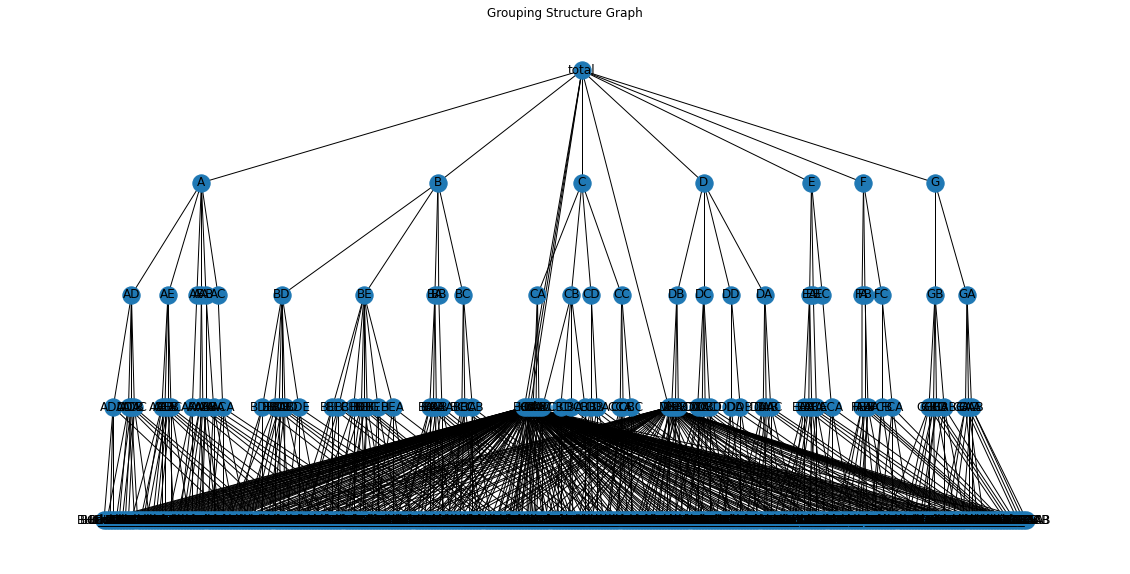

In [555]:
G = build_graph(states, zones, regions, purposes)
plot_graph_hierarchical(G)

# Drawing a subset of the graph

In [556]:
states = states[:2]
zones = zones[:8]
regions = regions[:16]
purposes = purposes[:2]

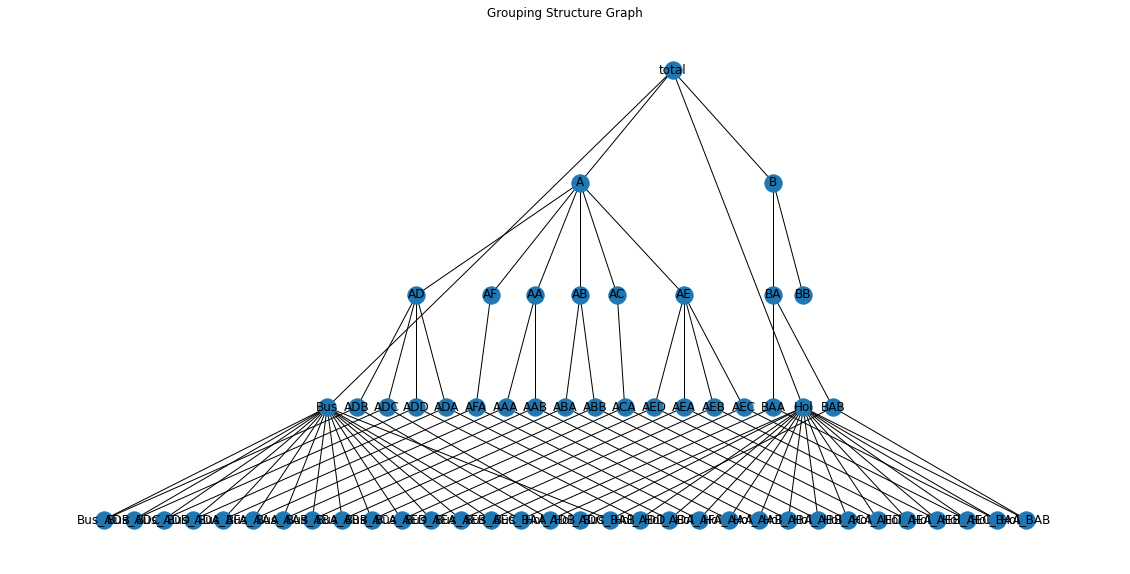

In [557]:
G = build_graph(states, zones, regions, purposes)
plot_graph_hierarchical(G)

# Extract the edges

In [558]:
edge_list = []
for edge_data in list(G.edges.data()):
    edge = []
    edge.append(edge_data[0])
    edge.append(edge_data[1])
    edge_list.append(edge)
edge_index = np.array(edge_list).T

In [559]:
edge_index.shape

(2, 92)

#### Should we add edge features? What could they be?

# Create the dataset and split train/test

In [560]:
A = torch.from_numpy(nx.adjacency_matrix(G).todense())

/tmp/ipykernel_1497639/2052951803.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = torch.from_numpy(nx.adjacency_matrix(G).todense())


In [561]:
edge_indices, values = dense_to_sparse(A)

In [562]:
train_dataset = StaticGraphTemporalSignal(
                edge_index = edge_indices.numpy(),
                edge_weight = values.numpy(),
                features = features_train,
                targets = target_train
            )

In [563]:
test_dataset = StaticGraphTemporalSignal(
                edge_index = edge_indices.numpy(),
                edge_weight = values.numpy(),
                features = features_test,
                targets = target_test
            )

Data sample:
* 419 nodes
* 1 feature (number of visitors)
* 12 timesteps per bucket (12 x 1 month = 1 year)
* Labels for 12 future timesteps (normalized number of visitors) --> node regression

In [564]:
next(iter(train_dataset))

Data(x=[419, 1, 24], edge_index=[2, 184], edge_attr=[184], y=[419, 12])

In [565]:
next(iter(test_dataset))

Data(x=[419, 1, 24], edge_index=[2, 184], edge_attr=[184], y=[419, 12])

In [566]:
#from torch_geometric_temporal.signal import temporal_signal_split
#train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [567]:
print("Number of train buckets: ", sum(1 for _ in train_dataset))
print("Number of test buckets: ", sum(1 for _ in test_dataset))

Number of train buckets:  181
Number of test buckets:  1


# Create and run the model

In [575]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN
from torch_geometric_temporal.signal import StaticGraphTemporalSignal


class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=1, periods=12)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(1, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(1, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(1, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [579]:
# GPU support
device = torch.device('cpu') # cuda

# Create model and optimizers
model = TemporalGNN(node_features=1, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
model.train()

print("Running training...")
for epoch in range(30): 
    loss = 0
    step = 0
    for snapshot in train_dataset:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.sqrt(torch.mean((y_hat-snapshot.y)**2)) # Root Mean Squared Error
        step += 1

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train RMSE: {:.4f}".format(epoch, loss.item()))

Running training...
Epoch 0 train MSE: 0.9910
Epoch 1 train MSE: 0.9885
Epoch 2 train MSE: 0.9875
Epoch 3 train MSE: 0.9872
Epoch 4 train MSE: 0.9873
Epoch 5 train MSE: 0.9872
Epoch 6 train MSE: 0.9869
Epoch 7 train MSE: 0.9865
Epoch 8 train MSE: 0.9862
Epoch 9 train MSE: 0.9860
Epoch 10 train MSE: 0.9856
Epoch 11 train MSE: 0.9852
Epoch 12 train MSE: 0.9850
Epoch 13 train MSE: 0.9848
Epoch 14 train MSE: 0.9846
Epoch 15 train MSE: 0.9846
Epoch 16 train MSE: 0.9841
Epoch 17 train MSE: 0.9838
Epoch 18 train MSE: 0.9837
Epoch 19 train MSE: 0.9833
Epoch 20 train MSE: 0.9833
Epoch 21 train MSE: 0.9829
Epoch 22 train MSE: 0.9829
Epoch 23 train MSE: 0.9826
Epoch 24 train MSE: 0.9826
Epoch 25 train MSE: 0.9824
Epoch 26 train MSE: 0.9823
Epoch 27 train MSE: 0.9822
Epoch 28 train MSE: 0.9821
Epoch 29 train MSE: 0.9819


# Evaluation

* Lets get some sample predictions for a specific horizon (e.g. 24 months)

## Multioutput

From 24 months of data predict the next 12

In [580]:
model.eval()
loss = 0
step = 0
horizon = 1

# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

Test MSE: 0.6208


## Multistep

From 24 months of data predict the $t+1$, use $[t-23:t+1]$ to predict $t+2$, use $[t-22:t+2]$ to predict $t+3$ and so on.

# COMPUTE THE MULTISTEP FORECAST

# Visualization

* The further away the point in time is, the worse the predictions get
* Predictions shape: [num_data_points, num_time_series, num_timesteps]

In [635]:
ts = 10
preds = np.squeeze(np.asarray([pred.detach().cpu().numpy() for pred in predictions]))
labs  = np.squeeze(np.asarray([label.cpu().numpy() for label in labels]))
print("Data points:,", preds.shape)

Data points:, (419, 12)


In [637]:
preds = scaler.inverse_transform(preds.T).T

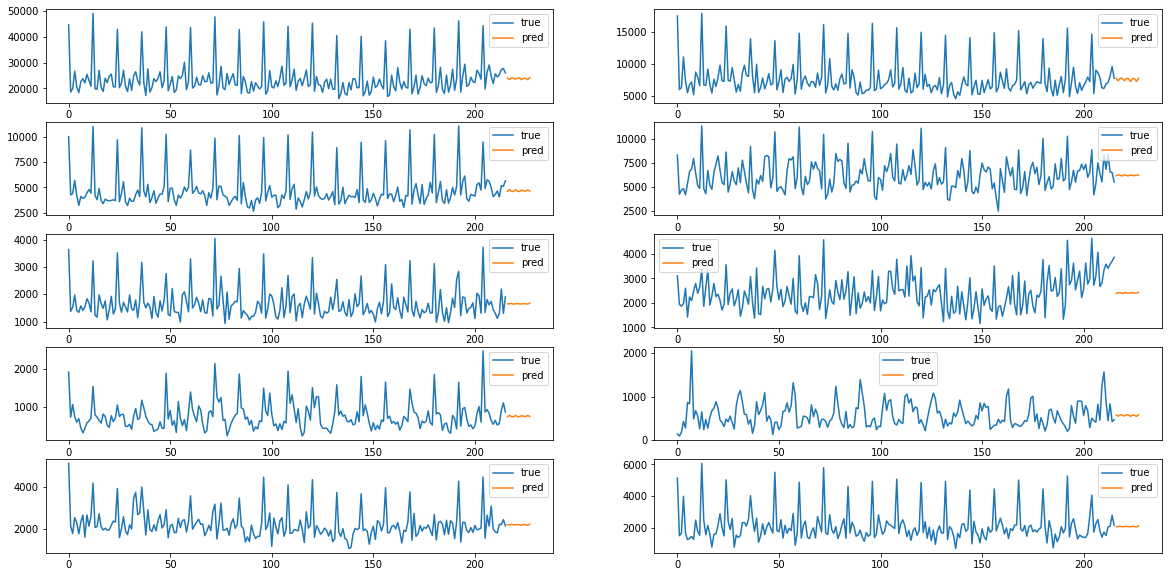

In [647]:
_, ax = plt.subplots(5, 2, figsize=(20, 10))

ax = ax.ravel()

for i in range(10):
    sns.lineplot(x=np.arange(216), y=visitors_train[i], label='true', ax=ax[i])
    sns.lineplot(x=np.arange(216, 228), y=np.squeeze(preds)[i], label="pred", ax=ax[i]);